In [1]:
import numpy as np
import emcee
from scipy.integrate import simps, trapz
from scipy.special import gammainc
import fsps

import matplotlib.pyplot as plt
import corner

# Cosmic SFH

## Part (a)

 Literature values of Schechter parameters are __*Cucciati et al 2012 (A&A 539: 31)* Table 1__ for z~0-4 and __*Bouwens et al 2015 (ApJ 803:24)* Table 6__ for z~4-8. Since Cucciati reports the values in redshift bins, I'll just choose the center of each redshift bin as the corresponding redshift.

In [2]:
z = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.5, 2.1, 3., 3.8, 4.9, 5.9, 6.8, 7.9])
Mstar = np.array([-18.12, -18.3, -18.4, -18.3, -18.7, -19.0, -19.6, -20.4, -20.97, -20.88, -21.17, -20.94, -20.87, -20.63])
Mstar_err = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.1, 0.14, 0.08, 0.12, 0.20, 0.26, 0.36])
phistar = np.array([7, 6.91, 6.6, 9.53, 9.01, 7.43, 4.1, 3.37, 1.71, 1.97, 0.74, 0.5, 0.29, 0.21]) * 1e-3
phistar_err = np.array([0.44, 0.95, 0.86, 0.99, 0.94, 1.08, 0.77, 0.24, 0.53, 0.29, 0.14, 0.16, 0.12, 0.11]) * 1e-3
alpha = np.array([-1.05, -1.17, -1.07, -0.9, -0.85, -0.91, -1.09, -1.3, -1.73, -1.64, -1.76, -1.87, -2.06, -2.02])
alpha_err = np.array([0.04, 0.05, 0.06, 0.08, 0.1, 0.16, 0.23, 0.23, 0.13, 0.04, 0.05, 0.10, 0.13, 0.23])

In [3]:
print len(Mstar), len(phistar), len(alpha), len(Mstar_err), len(phistar_err), len(alpha_err)

14 14 14 14 14 14


In [6]:
# needed in conversion from M_star to L_star
g = fsps.get_filter('galex_fuv')
print g.msun_ab
Lsun = 4*np.pi*(10*3.085677581467192 * 10**18)**2*10**(-0.4*(17.24-2.5 * np.log10(3631 * 10**(-23))))
print Lsun

17.24
5.51997617647e+13


In [4]:
### Schechter function here
def schechter(M, Mstar, phistar, alpha):
    x = 10**(-0.4*(M-Mstar))
    model = (np.log(10)/2.5)*phistar*x**(alpha+1)*np.exp(-x)
    return model

In [7]:
### compute UV luminosity density, rho_uv by integrating over magnitudes from -23 to -17 (like Finkelstein et al)
### in order to generate errors, we'll draw 100 Monte Carlo samples from Gaussian distributions assumed on the
### Schechter function coefficients

np.random.seed(11)
rho_uv = np.empty(14)
rho_uv_err = np.empty(14)
mags = np.linspace(-23, -17, num=500)
for i in range(14):
    # draw 100 MC coefficient samples
    Mstar_mc = np.random.normal(Mstar[i], Mstar_err[i], size=100)
    phistar_mc = np.random.normal(phistar[i], phistar_err[i], size=100)
    alpha_mc = np.random.normal(alpha[i], alpha_err[i], size=100)
    # generate a storage vector for phi
    rho_uv_mc = np.empty(100)
    Lstar_i = 10**(-0.4*(Mstar[i]-17.24))* Lsun
    for j in range(100):    
        phi = schechter(mags, Mstar_mc[j], phistar_mc[j], alpha_mc[j]) * Lstar_i * 10**(-0.4*(mags-Mstar_mc[j]))
        rho_uv_mc[j] = trapz(phi, mags)
    rho_uv[i] = np.mean(rho_uv_mc)
    rho_uv_err[i] = np.std(rho_uv_mc)

In [26]:
### compute UV luminosity density, rho_uv by using the formula from Madau & Dickinson
rho_uv = np.empty(len(z))
mags = np.linspace(-23, -17, num=100)
for i in range(len(z)):
    Lstar_i = 10**(-0.4*(Mstar[i]-17.24))* Lsun
    rho_uv_i = gammainc(2+alpha[i], 0.03) * phistar[i] * Lstar_i
    rho_uv[i] = rho_uv_i    

In [8]:
print rho_uv
print rho_uv_err

[  3.75287526e+25   4.56503751e+25   4.93053356e+25   6.46459345e+25
   9.60954036e+25   1.07921699e+26   1.19361373e+26   2.49904637e+26
   3.69078300e+26   3.37564749e+26   2.02962505e+26   1.25755554e+26
   1.11051623e+26   6.01241894e+25]
[  2.57239779e+24   6.39560175e+24   7.62920264e+24   6.56929736e+24
   1.11983962e+25   1.57751254e+25   2.42386619e+25   4.88494204e+25
   1.30507668e+26   5.30923268e+25   4.19898463e+25   4.53790917e+25
   5.36161751e+25   4.65024374e+25]


In [12]:
### from PSET 5 get the value of kappa_uv = nu_fuv/C_fuv
kappa_uv = 8.87e-29
#kappa_uv = 1.25e-28
print 1.25e-28/8.87e-29

1.40924464487


In [10]:
### star formation rate density here
rho_sfr = kappa_uv * rho_uv
rho_sfr_err = np.abs(kappa_uv * rho_uv_err)
print rho_sfr
print rho_sfr_err

[ 0.0033288   0.00404919  0.00437338  0.00573409  0.00852366  0.00957265
  0.01058735  0.02216654  0.03273725  0.02994199  0.01800277  0.01115452
  0.00985028  0.00533302]
[ 0.00022817  0.00056729  0.00067671  0.0005827   0.0009933   0.00139925
  0.00214997  0.00433294  0.01157603  0.00470929  0.0037245   0.00402513
  0.00475575  0.00412477]


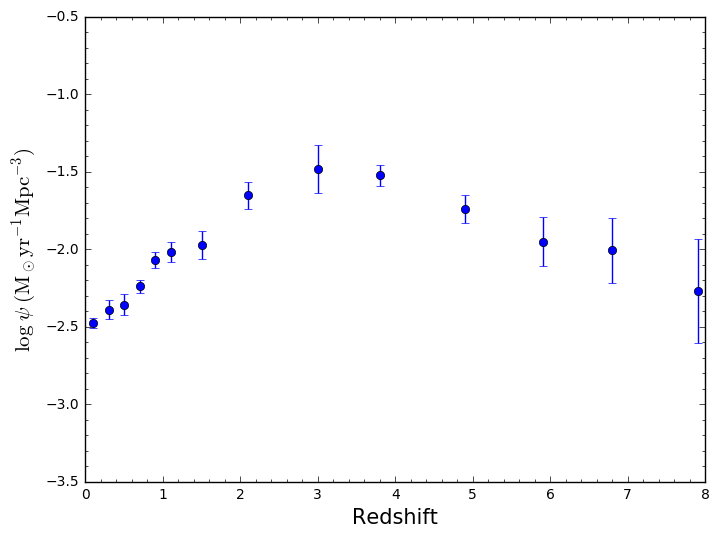

In [11]:
fig = plt.figure(figsize=(8,6))
plt.errorbar(z, np.log10(rho_sfr), yerr=rho_sfr_err/(np.log(10)*rho_sfr), fmt='o')
#plt.plot(z, np.log10(0.002*(1+z)**2.1), c='r')
#plt.plot(z, np.log10((1+z)**(-2.4)), c='g')
#plt.plot(z, np.log10(A*((1+z)**alpha/(1+((1+z)/B)**gamma))), c='k', ls='--')
plt.minorticks_on()
plt.xlim(left=0)
plt.ylim([-3.5,-0.5])
plt.xlabel('Redshift', fontsize=15)
plt.ylabel(r'${\rm \log \; \psi \; (M_\odot yr^{-1} Mpc^{-3})}$', fontsize=15)
plt.show()

My plot looks similar to the Finkelstein et al 2015 Figure 19 -- the SFR density is increasing going from z~8 to z~3, and then it starts to decrease.

Possible differences due to:
- different calibration when converting from FUV luminosity density to SFR density (Finkelstein $\kappa_{\text{UV}}$ is 1.4 times bigger than my value)
- different Schechter parameters for z~0-4 (I used Cucciati et al 2012, Finkelstein used a combination of Reddy+09 and Arnouts+05)
    - the Cucciati et al paper reports their values in terms of redshift bins, so depending on how one chooses the redshift points you could have a differently looking plot
- different procedure to compute the cosmic SFRD (they used the MCMC luminosity fitting chains chains, while I had to use the quoted Schechter parameter values to generate random values; since the parameters come from different sources which probably derived them in different ways, there might be different uncertainties folded into them)

## Part (b)

In [26]:
### probabilites here
def lnlike(theta, z, psi, psierr):
    A, B, alpha, gamma = theta[0], theta[1], theta[2], theta[3]
    model = A*((1+z)**alpha/(1+((1+z)/B)**gamma))
    return -0.5*np.sum((psi-model)**2/(psierr**2) + np.log(2*np.pi*psierr**2))

def lnprior(theta):
    A, B, alpha, gamma = theta[0], theta[1], theta[2], theta[3]
    if 0.001 < A < 0.005 and 2.5 < B < 10. and 0.5 < alpha < 3.5 and 2. < gamma < 40.:
        return 0
    return -np.inf

def lnprob(theta, z, psi, psierr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, z, psi, psierr)

In [27]:
### emcee here
ndim, nwalkers = 4, 400
pos = [np.array([0.002,5.1,1.8,7.0])+1e-4*np.random.randn(ndim) for i in range(nwalkers)]
emcee_sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(z, rho_sfr, rho_sfr_err))
pos1, prob, state = emcee_sampler.run_mcmc(pos, 2000)
emcee_sampler.reset()
emcee_sampler.run_mcmc(pos1, 5000, rstate0=state);

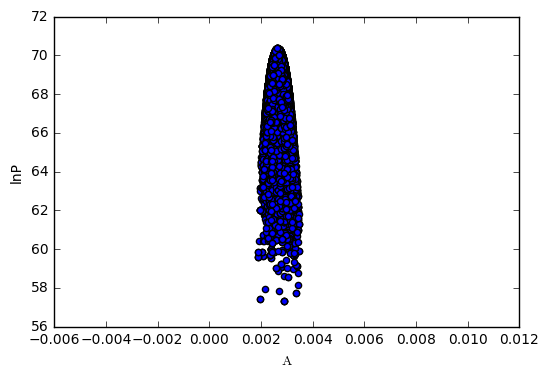

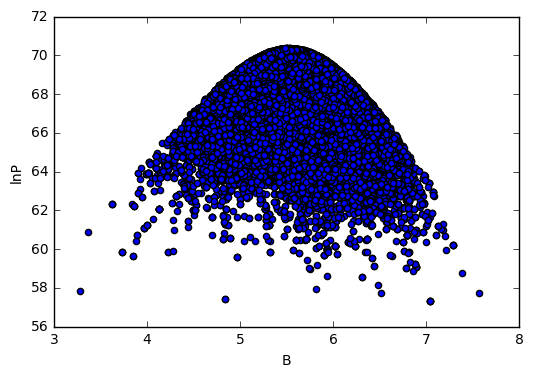

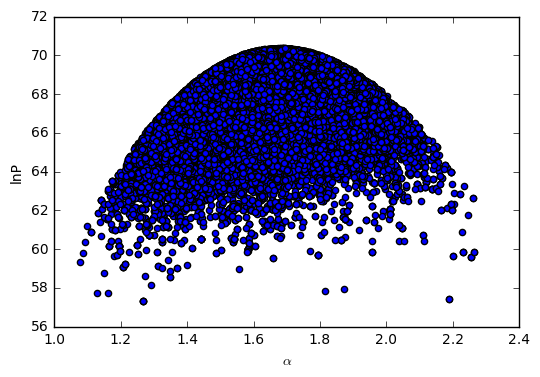

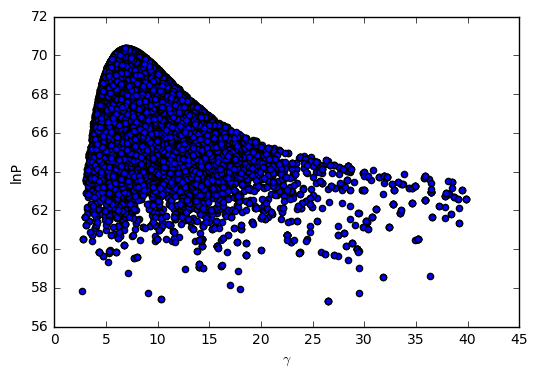

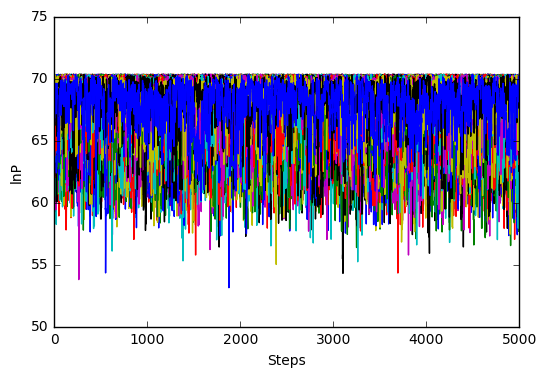

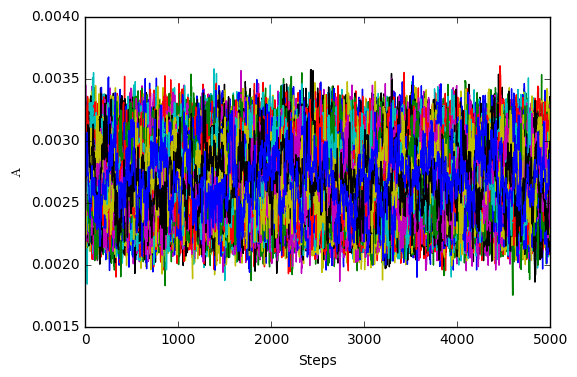

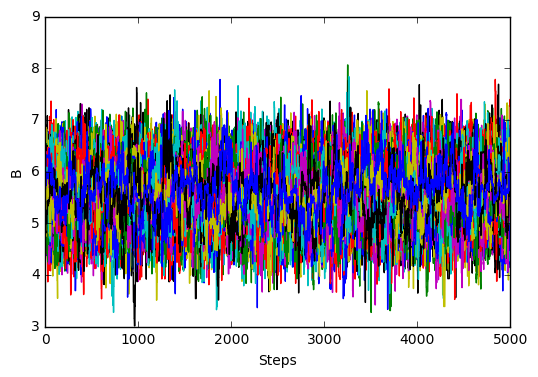

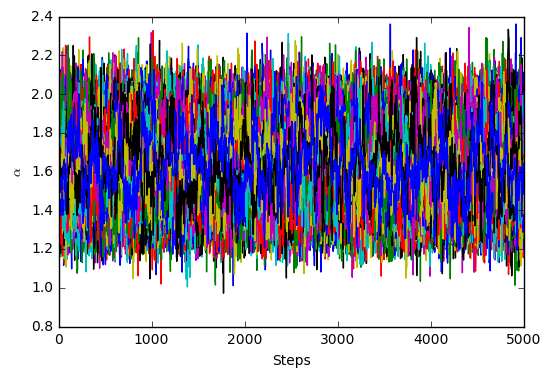

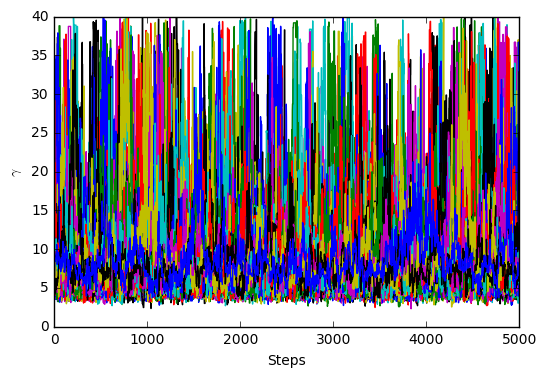

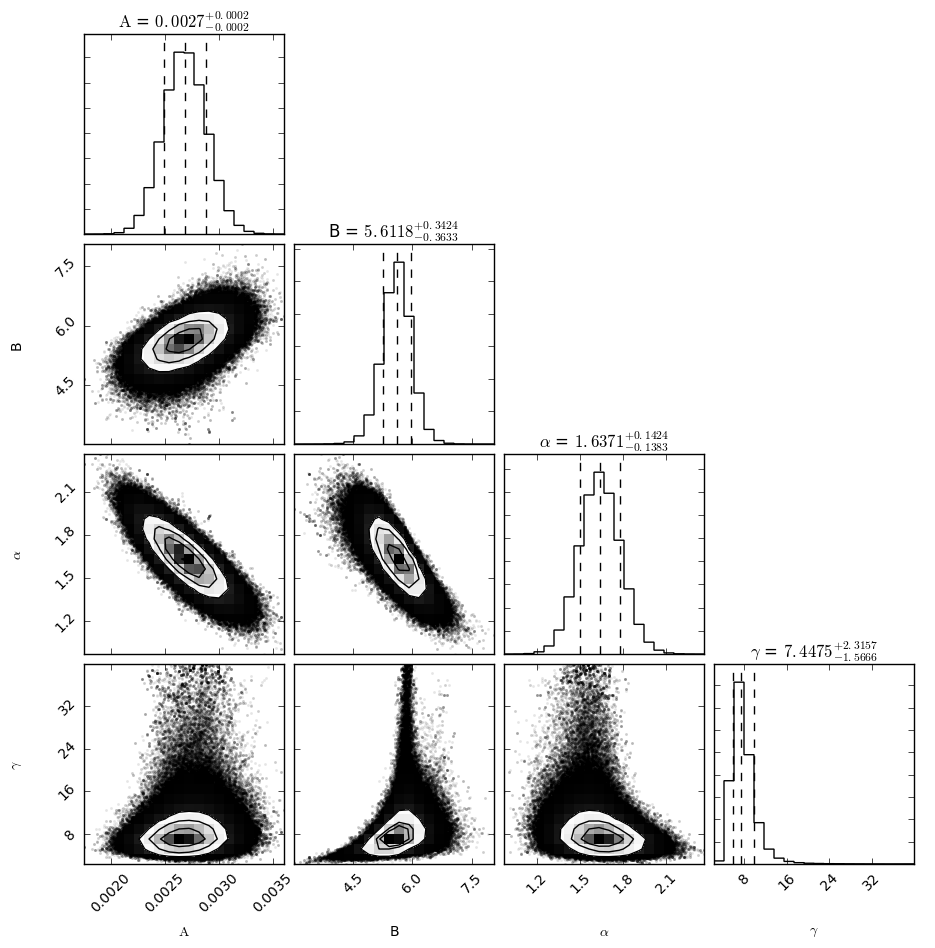

In [28]:
[plt.scatter(emcee_sampler.chain[i,:,0], emcee_sampler.lnprobability[i,:]) for i in range(30)]
plt.xlabel(r'${\rm A}$')
plt.ylabel('lnP')
plt.show()

[plt.scatter(emcee_sampler.chain[i,:,1], emcee_sampler.lnprobability[i,:]) for i in range(30)]
plt.xlabel(r'B')
plt.ylabel('lnP')
plt.show()

[plt.scatter(emcee_sampler.chain[i,:,2], emcee_sampler.lnprobability[i,:]) for i in range(30)]
plt.xlabel(r'$\alpha$')
plt.ylabel('lnP')
plt.show()

[plt.scatter(emcee_sampler.chain[i,:,3], emcee_sampler.lnprobability[i,:]) for i in range(30)]
plt.xlabel(r'$\gamma$')
plt.ylabel('lnP')
plt.show()

[plt.plot(emcee_sampler.lnprobability[i,:]) for i in range(nwalkers)]
plt.xlabel('Steps')
plt.ylabel('lnP')
plt.show()

[plt.plot(emcee_sampler.chain[i,:,0]) for i in range(nwalkers)]
plt.xlabel('Steps')
plt.ylabel(r'${\rm A}$')
plt.show()

[plt.plot(emcee_sampler.chain[i,:,1]) for i in range(nwalkers)]
plt.xlabel('Steps')
plt.ylabel(r'B')
plt.show()

[plt.plot(emcee_sampler.chain[i,:,2]) for i in range(nwalkers)]
plt.xlabel('Steps')
plt.ylabel(r'$\alpha$')
plt.show()

[plt.plot(emcee_sampler.chain[i,:,3]) for i in range(nwalkers)]
plt.xlabel('Steps')
plt.ylabel(r'$\gamma$')
plt.show()

emcee_samples = emcee_sampler.chain[:,:, :].reshape((-1, ndim))
fig = corner.corner(emcee_samples, labels=[r"${\rm A}$", r"B", r"$\alpha$", r"$\gamma$"], quantiles=[0.16, 0.5, 0.84], \
                    show_titles=True, title_fmt='.4f')
plt.show(fig)

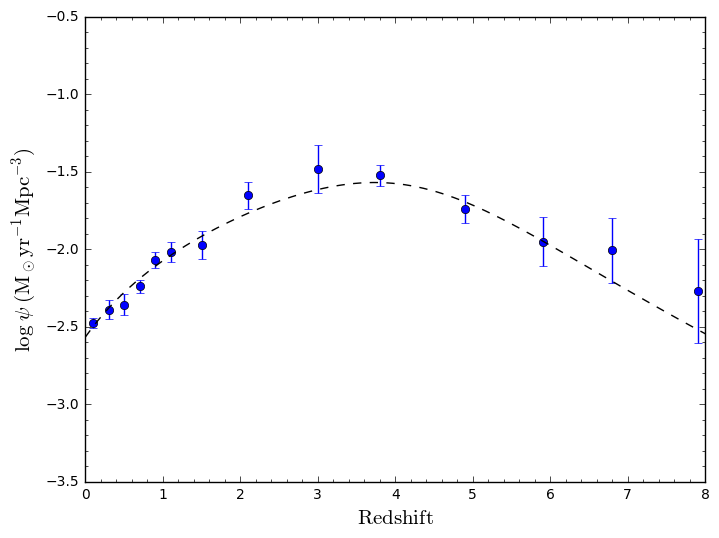

In [30]:
A = 0.0027
B = 5.6118
alpha = 1.6371
gamma = 7.4475
fig = plt.figure(figsize=(8,6))
plt.errorbar(z, np.log10(rho_sfr), yerr=rho_sfr_err/(np.log(10)*rho_sfr), fmt='o')
plt.plot(np.linspace(0,8,100), np.log10(A*((1+np.linspace(0,8,100))**alpha/(1+((1+np.linspace(0,8,100))/B)**gamma))), c='k', ls='--')
plt.minorticks_on()
plt.xlim(left=0)
plt.ylim([-3.5,-0.5])
plt.xlabel(r'${\rm Redshift}$', fontsize=15)
plt.ylabel(r'${\rm \log \; \psi \; (M_\odot yr^{-1} Mpc^{-3})}$', fontsize=15)
plt.show()

The possible differences from part (a) are going to propagate into the determination of the four best-fit parameters of this part. In particular, the points for z less than 3 are different than the ones used by Finkelstein, so they could skew the particular shape of the best fit line. Also, the Madau & Dickinson plot is different from the Finklestein plot by about an order of magnitude and they are, in principle, trying to fit the same quantity.